In [26]:
import os
from typing import List, Tuple, Dict
from IPython.utils import io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Question 1  
(-1/5, 1.0). emperically calcualated

Question 2

In [3]:
# Load data
path1 = './data/finance_data/Name_sector.csv'
path2 = './data/finance_data/data/'
n_rows = 765 # many files in finance_data/data have 765 rows (+1 for header), we only use these ones
n_files = len(os.listdir(path2))

stock_prices = []
stock_names = []
stock_sectors = []
with open(path1, 'r') as name_sector_f:
    line = name_sector_f.readline()
    for f in os.listdir(path2):
        if len(f) > 3 and f[-3:] == 'csv': # skip DS_Store file
            line = name_sector_f.readline()
            n_lines = sum(1 for _ in open(path2 + f))
            if n_lines == n_rows + 1: # +1 for header
                name, sector = line.strip().split(',') # strip() removes \n
                stock_names.append(name)
                stock_sectors.append(sector)
                stock_prices.append(np.genfromtxt(path2 + f, delimiter=',', skip_header=1, usecols=4, dtype=np.float64))

stock_prices = np.array(stock_prices)

Text(0, 0.5, 'Frequency')

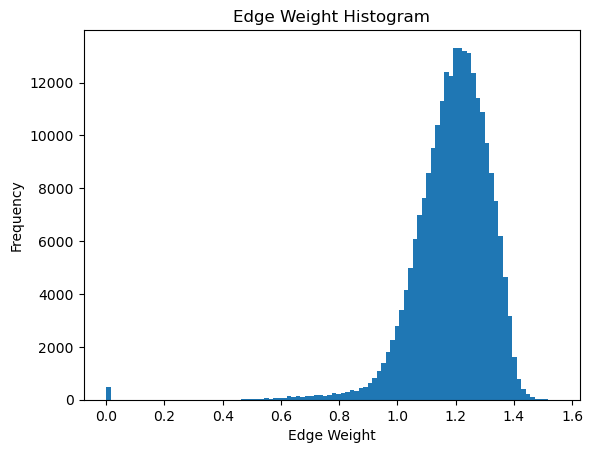

In [4]:
# Calculate values from Question 1
qi_t = (stock_prices[:, 1:] - stock_prices[:, :-1]) / stock_prices[:, :-1]
ri_t = np.log(1 + qi_t)
corr = np.corrcoef(ri_t)
assert len(corr) == len(stock_prices)

# Create graph and plot edge weight histogram
edges = np.sqrt(2 * (1 - corr))
# edges[np.abs(edges) < 1e-3] = 0
G = nx.from_numpy_matrix(edges)
for i in range(len(stock_sectors)):
    G.nodes[i]['sector'] = stock_sectors[i]
    G.nodes[i]['name'] = stock_names[i]
_ = plt.hist(edges.flatten(), bins=100)
plt.title('Edge Weight Histogram')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')

Question 3

The MST shows a few cor sectors that all sectors are related to (financials, industrials, and to a limited extent consumer discretionary). Other sectors such as utilities or energy are very independent of other sectors. The pattern makes sense since sectors like energy and real estate being linked make natural sense. Moreover financials track much of the economy and make sense to be linked with many sectors

In [17]:
sectors

('Utilities',
 'Materials',
 'Information Technology',
 'Health Care',
 'Financials',
 'Telecommunication Services',
 'Consumer Staples',
 'Real Estate',
 'Energy',
 'Consumer Discretionary',
 'Industrials')

In [52]:
class MSTPlotter:
    """Helper class for questions 3 and 4
    """

    def __init__(self, G: nx.Graph, mst: nx.Graph):
        self._mst = mst
        self._pos = nx.kamada_kawai_layout(self._mst)

    def plot(self, colors: np.ndarray, groups_titles: List, legend_title: str, title: str, figsize: Tuple = (11, 11)) -> None:
        """Plots the MST with nodes colored by sector and edges colored by group.

        Parameters
        ----------
        colors : np.ndarray
            Array of colors for each node.
        groups_titles : List
            list of titles of each group used for creating a legend (ie communities or sectors)
        legend_title : str
        title: str
        figsize : Tuple
        """
        if len(groups_titles) < 11:
            cmap = plt.cm.tab10
        elif len(groups_titles) < 21:
            cmap = plt.cm.tab20
        else:
            cmap = plt.cm.magma

        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(self._mst, self._pos, node_size=100, node_color=colors, cmap=cmap)
        nx.draw_networkx_edges(self._mst, self._pos, width=1)
        colors = cmap(np.linspace(0, 1, len(groups_titles)))
        with io.capture_output() as captured:
            for i in range(len(groups_titles)):
                plt.scatter([], [], c=colors[i], label=groups_titles[i])
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title=legend_title)
        plt.title(title)
        plt.show()

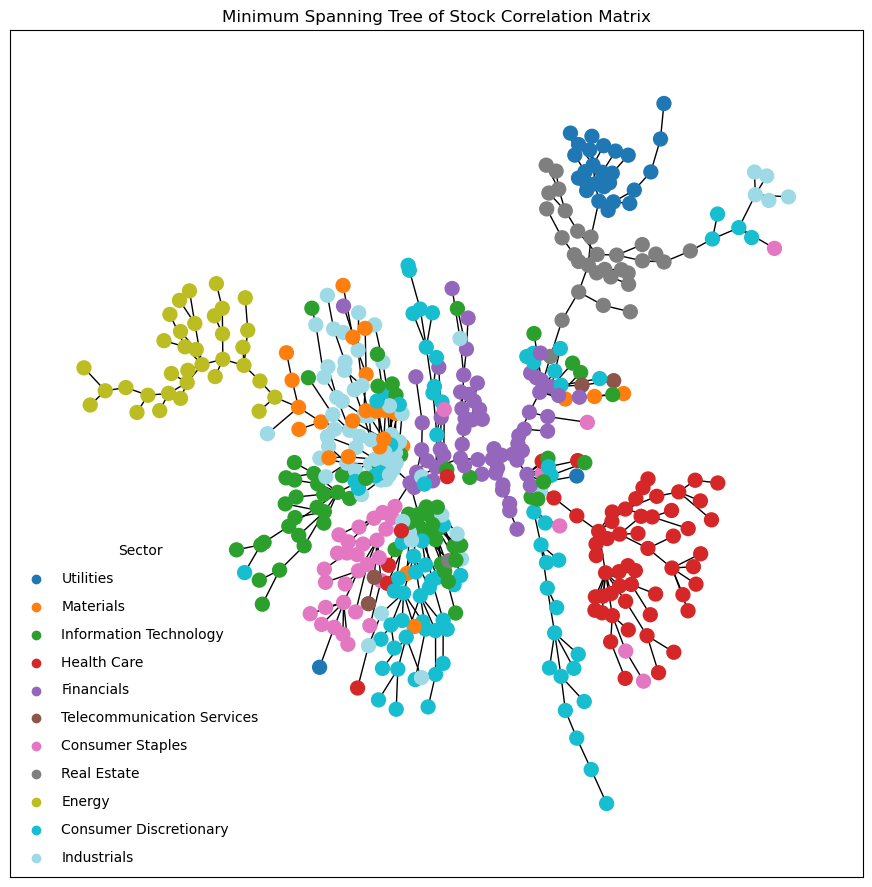

In [53]:
mst = nx.minimum_spanning_tree(G)

# Find and color sector nodes
sectors = tuple(set(stock_sectors))
sector_colors = np.empty(len(G.nodes), dtype=np.int64)
for i, sector1 in enumerate(sectors):
    for j, sector2 in enumerate(stock_sectors):
        if sector1 == sector2:
            sector_colors[j] = i

mst_plotter = MSTPlotter(G, mst)
mst_plotter.plot(sector_colors, sectors, 'Sector', 'Minimum Spanning Tree of Stock Correlation Matrix')

Question 4

QUESTION 4: Run a community detection algorithm (for example walktrap) on the MST ob-
tained above. Plot the communities formed. Compute the homogeneity and completeness of the
clustering. (you can use the ’clevr’ library in r to compute homogeneity and completeness).

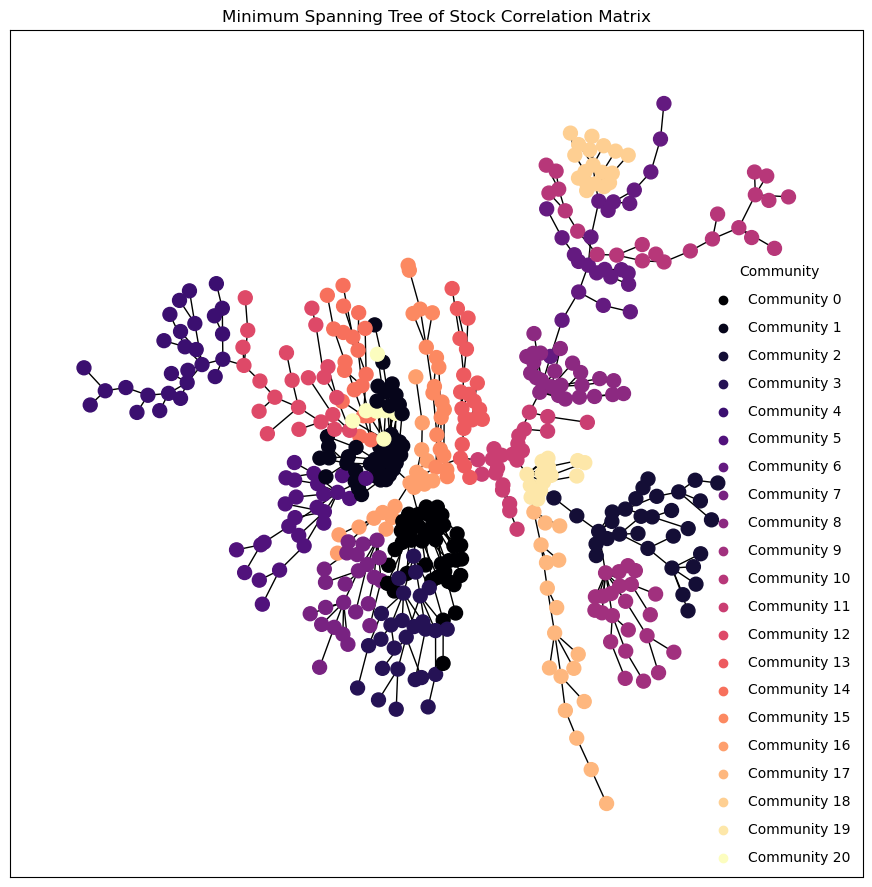

In [54]:
# Find and color communities
communities = nx.algorithms.community.greedy_modularity_communities(mst)
community_colors = np.empty(len(G.nodes), dtype=np.int64)
for i in range(len(communities)):
    for j in communities[i]:
        community_colors[j] = i

# Plot
community_titles = [f'Community {i}' for i in range(len(communities))]
mst_plotter.plot(community_colors, community_titles, 'Community', 'Minimum Spanning Tree of Stock Correlation Matrix')

Question 5

Question 6